<div class="alert alert-info">
<strong>Authors:</strong> Oxoli Daniele, Capizzi Emanuele - 2022 - Politecnico di Milano <br>
<strong>License:</strong> MIT
</div>

<div class="alert alert-block alert-success">
<h1>Create a personalized dashboard for requesting data using WEkEO HDA API</h1></div>

# NOTEBOOK INTRODUCTION

### Data used in this example

| Product Description | Link | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-----------------:|:-----------------:|
| ERA5 - Single Levels | <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview" target="_blank">link</a> | EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AERA5_HOURLY_VARIABLES_ON_PRESSURE_LEVELS" target="_blank">link</a> |
|CAMS - European Air Quality Forecasts|<a href="https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview" target="_blank">link</a>|EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3ACAMS_EUROPE_AIR_QUALITY_FORECASTS" target="_blank">link</a>|
|CEMS - River discharge and related historical data from the European Flood Awareness System|<a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/efas-historical?tab=overview" target="_blank">link</a>|EO:ECMWF:DAT:EFAS_HISTORICAL|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AEFAS_HISTORICAL" target="_blank">link</a>|
|CMEMS - Atlantic- European North West Shelf- Ocean Physics Reanalysis|<a href="https://resources.marine.copernicus.eu/product-detail/NWSHELF_MULTIYEAR_PHY_004_009/INFORMATION" target="_blank">link</a>|EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AMO%3ADAT%3ANWSHELF_ANALYSISFORECAST_PHY_LR_004_001" target="_blank">link</a>|

### Learning outcomes

At the end of this notebook you will know:
* How to access [*<span style='color:Blue'>WEkEO</span>*](https://www.wekeo.eu/) datasets using [*<span style='color:Blue'>HDA API</span>*](https://www.wekeo.eu/docs/harmonised-data-access-api) and the [*<span style='color:Blue'>requests</span>*](https://docs.python-requests.org/en/latest/) Python library;
* How to create a simple dashboard using Jupyter Notebooks widgets. They are provided by the [*<span style='color:Blue'>Ipywidgets</span>*](https://ipywidgets.readthedocs.io/en/latest/) library and can be useful to automatize data access directly from your Jupyter Notebook
* How to use GET and POST requests to get data from HDA API.


### Outline
 
This notebook aims to show how to create simple interactive dashboards for downloading data from WEkEO DIAS. The purpose is to show and create blocks of code that can be reused for other available datasets.

API endpoints are available at the following link: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/ui/#/

The example code can be adapted according to the metadata of the requested resource. (improve description).

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Login section](#login)   
 2. [Datasets exploration](#exploration) 
 3. [Section 1 - ERA5 Reanalysis Single Levels](#section1)
 4. [Section 2 - CAMS - Europe Air Quality Forecasts](#section2)
 5. [Section 3 - CEMS - EFAS Historical](#section3)
 6. [Section 4 - CMEMS - Analysis/Forecast Sea Bottom Temperature](#section4)


<hr>

<div class="alert alert-info" role="alert">

## <a id='libraries'></a>Import libraries

</div>

In [1]:
import requests
import json
import pandas as pd
import base64
import ipywidgets as widgets
from ipywidgets import Layout
from PIL import Image
import numpy as np
import rioxarray as rxr
import xarray as xr
from IPython.display import display, JSON
import IPython
from urllib.request import urlopen
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl
import matplotlib.ticker as mticker
import imageio
from pathlib import Path
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

C:\Users\Administrator\anaconda3\envs\copernicus\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [58]:
%load_ext autoreload
%autoreload 2
import simplified_WEkEO_methods as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-info" role="alert">

## <a id='login'></a> Login section
[Back to top](#TOC_TOP)

</div>

The following widget allows to login with your WEkEO credentials and obtain the token. It's necessary to insert the Username and Password without launching the cell again:

In [3]:
username = m.text_widget("Insert username: ")
password = m.password_widget("Insert password: ")

login_box = widgets.VBox([username, password])
login_box

Username and Password are saved into the respective variables and they are used to retrieve a temporary access token using the following API endpoint:

![gettoken.jpeg](images/gettoken.jpg)

It is also necessary to define a **headers** variable for the authorization.

In [4]:
message = str(username.value+":"+password.value).encode('ascii')
base64_message = base64.b64encode(message).decode('ascii')
headers = {'authorization': 'Basic '+base64_message}
token_request = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/gettoken", headers=headers)
token_text = json.loads(token_request.text)
print("Your access token is: "+token_text['access_token'])
headers = {'authorization': token_text['access_token']}
token = list(headers.values())[0]

Your access token is: cdbde349-c616-3c91-9aba-0a00a4561f79


<div class="alert alert-info" role="alert">

## <a id='exploration'></a> WEkEO Datasets exploration
[Back to top](#TOC_TOP)

</div>

First of all we are going to create a list containing the HDA ID for the chosen datasets used in this notebook. Similarly to what was done previously, it is possible to access these data using the [*<span style='color:Blue'>requests </span>*](https://docs.python-requests.org/en/latest/) Python library to send the request to the API service. Finally, we can obtain a Pandas dataframe containing all the datasets and their information available from WEkEO DIAS:

In [ ]:
size = 2000 # Max number of datasets to be requested (the total number is 1018)
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df # Show the first 5 datasets

Another option is to get the dataset ID manually from the WEkEO portal, instead of using the previous dataframe:

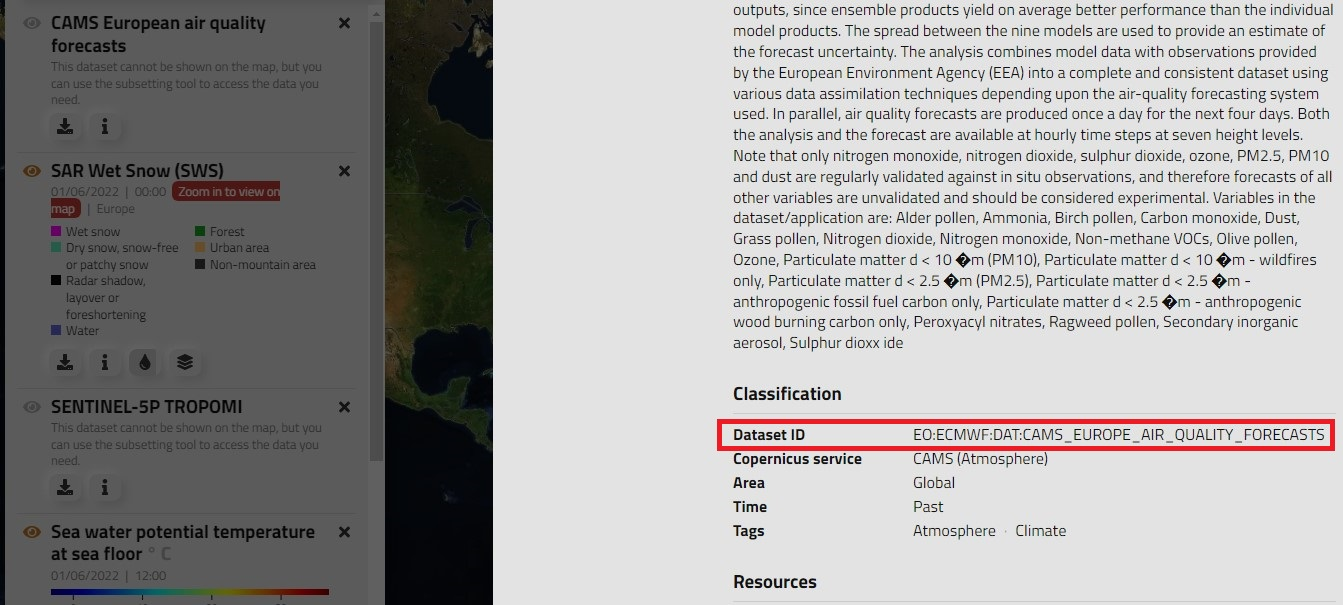

As previously explained, for the purpose of this notebook we will use four different interesting datasets coming from different Copernicus Services. They are saved in the following list for our next examples:

In [ ]:
ds_list = ['EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS',
          'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS',
          'EO:ECMWF:DAT:EFAS_HISTORICAL',
          'EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m']

----

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Section 1 - ERA5 Reanalysis Single Levels
[Back to top](#TOC_TOP)

</div>

The first dataset used as example is the ERA5 Reanalysis Single Levels. We already added its HDA ID in the **ds_list** as first step. We can create a dropdown menu to select the dataset we want to use. The dropdown menu can be useful to store information and access them interactively:

In [ ]:
dataset_id = m.get_dropdown(ds_list, "List of datasets:")
dataset_id

Always using the request, we can filter the dataset we are interested in:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

We now have information about:
 - Abstract
 - HDA dataset ID (we already saved it in the ds_list during the datasets exploration)
 - Dataset preview image
 - Dataset title

For example we can use the dataset title, preview image and the abstract to create a simple preview of the dataset. It can be useful to check if the dataset it's correct or to read its description:

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display image using IPython
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(header=title_box, right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 1.7, '60px'])
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Moving forward the creation of the dashboard, it is possible to access the metadata for this dataset as follows:

![metadata.jpeg](images/metadata.jpg)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

We can interactively visualize the metadata using the display function for IPython library. This is very useful to understand how the metadata JSON file is structured and how it can be exploited to create the next requests:

In [ ]:
display(JSON(metadata))

The ERA5 single level dataset contains many variables that can be selected. We need to obtain a list of variables from the metadata:

In [ ]:
category = metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels']
category_list = []
params_list = []
for item in category:
    category_list.append(item['valuesLabels'])

for item in category_list:
    key_list = list(item.keys())
    params_list.append(key_list)

variables_list = [item for sublist in params_list for item in sublist]

Always keeping the metadata as reference, we can select the other necessary variables:

In [ ]:
format_type_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
year_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
month_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
day_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
time_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

As final step we can create the widgets for the dashboard. In this case multiple selection and radio buttons widgets are used:

In [ ]:
params_sel = m.select_multiple(variables_list, "Variable: ")
product_type_sel = m.select_multiple(product_type_list, "Product type:")
year_sel = m.select_multiple(year_list, "Year: ")
month_sel = m.select_multiple(month_list, "Month: ")
day_sel = m.select_multiple(day_list, "Day: ")
time_sel = m.select_multiple(time_list, "Time: ")
format_type_sel = m.select_buttons(format_type_list, "Format: ", "netcdf")

Finally, we can now group all the widgets in a single dashboard interface. This notebook is created using netCDF files, but it can be adapted to use GRIB files as well:

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, year_sel, month_sel, day_sel, time_sel, format_type_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          left_sidebar=variables_box,
          layout=widgets.Layout(border='solid'),
          grid_gap="300px")

container = widgets.Box([ui])
display(container)

Selecting the parameter in the dashboard above will automatically change the requested data inside the following query. The query will be used for the POST request. Notice also the **headers** variable is changed in this cell:

![datarequest.jpeg](images/datarequest.jpg)

After the request is completed we can obtain the Job ID that will allows us to effectively download the data:

In [ ]:
query = {
  "datasetId": dataset_id.value,
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": list(params_sel.value)
    },
    {
      "name": "year",
      "value": list(year_sel.value)
    },
    {
      "name": "month",
      "value": list(month_sel.value)
    },
    {
      "name": "day",
      "value": list(day_sel.value)
    },
    {
      "name": "time",
      "value":list(time_sel.value)
    },
    {
      "name": "product_type",
      "value": list(product_type_sel.value)
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": format_type_sel.value
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)
}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

Check when the request is completed:

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

Now that we have the Job ID, we can request the data using the following cell (RE-RUN THE FOLLOWING CODE IF NOT WORKING). Notice that the **headers** changed again since we are doing a GET request:

![jobid.jpeg](images/jobid.jpg)

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

The following Radio Buttons widget can be used to decide whether we cant to save the netCDF file in the working directory or read it directly:

In [ ]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = m.select_buttons(download_list, "Data download: ", "Read NETCDF in memory")
download_sel

The **download_type** is used to download or read the file directly:

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)

We are ready to plot the netCDF file previously requested:

In [ ]:
variables = list(ds.keys())
var_drop = m.get_dropdown(variables, "Variable: ")
var_drop

In [ ]:
ds_data = ds[var_drop.value]
ds_data

In [ ]:
f = plt.figure(figsize=(15,10))
p = ds_data.isel(time=0).plot(  #change time
subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
transform=ccrs.PlateCarree())
p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.AutoLocator()
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
for date in ds.time.values:
    ds_data = ds[var_drop.value].sel(time=date).squeeze()
    
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    p = ds_data.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
    ax.coastlines()

    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

    # draw parallels/meridiens and write labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    
    plt.savefig('out/map_{}.png'.format(np.datetime_as_string(date,'D')))
    plt.close()

In [ ]:
import imageio
from pathlib import Path
from IPython.display import Image

im_path = Path('out')
images = im_path.glob('map_*.png')
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite('./out/map_gif.gif', image_list, duration = 1, loop = 10)

with open('out/map_gif.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

----

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Section 2 - CAMS - Europe Air Quality Forecasts
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = m.get_dropdown(ds_list, "List of datasets: ")
dataset_id

Select 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS' from the Dropdown list:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(header=title_box, right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
format_type_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
params_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
level_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
type_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
hour_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
leadtime_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

In [ ]:
params_sel = m.select_multiple(params_list, "Variable:")
product_type_sel = m.select_multiple(product_type_list, "Product type:")
level_sel = m.select_multiple(level_list, "Level: ")
type_sel = m.select_multiple(type_list, "Type: ")
hour_sel = m.select_multiple(hour_list, "Hour: ")
leadtime_sel = m.select_multiple(leadtime_list, "Leadtime hour: ")
format_type_sel = m.select_buttons(format_type_list, "Format: ", "netcdf")
start_date_sel = m.get_date_picker("Select start date: ")
end_date_sel = m.get_date_picker("Select start end: ")

In [ ]:
cams_map, dc = m.draw_map(45, 10, 4)

cams_map

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

In [ ]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date)

In [ ]:
title_box = widgets.HTML('<h2>CAMS European air quality forecasts </h2>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, level_sel, type_sel, hour_sel, leadtime_sel, start_date_sel, end_date_sel, format_type_sel])

ui = widgets.AppLayout(
          left_sidebar=variables_box,
          layout=widgets.Layout(border='solid'),
          grid_gap="300px")

# compute_button.on_click(compute_button_f)
container = widgets.Box([ui])
display(container)

In [ ]:
query = {
      "datasetId": dataset_id.value,
      "boundingBoxValues": [
        {
          "name": "area",
          "bbox": [
            W,
            N,
            E,
            S
          ]
        }
      ],
      "dateRangeSelectValues": [
        {
          "name": "date",
          "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
          "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
        }
      ],
      "multiStringSelectValues": [
        {
          "name": "variable",
          "value": list(params_sel.value)
        },
        {
          "name": "model",
          "value": list(product_type_sel.value)
        },
        {
          "name": "level",
          "value": list(level_sel.value)
        },
        {
          "name": "type",
          "value": list(type_sel.value)
        },
        {
          "name": "time",
          "value": list(hour_sel.value)
        },
        {
          "name": "leadtime_hour",
          "value": list(leadtime_sel.value)
        }
      ],
      "stringChoiceValues": [
        {
          "name": "format",
          "value": format_type_sel.value
        }
      ]
    }
      
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

In [ ]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = m.select_buttons(download_list, "Data download: ", "Read NETCDF in memory")
download_sel

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)

In [ ]:
ds = ds.sortby('longitude')

In [ ]:
variables = list(ds.keys())
var_drop = m.get_dropdown(variables, "Variable: ")
var_drop

In [ ]:
ds_data = ds[var_drop.value]
ds_data

In [ ]:
f = plt.figure(figsize=(15,10))
p = ds_data.isel(time=0).plot(  #change time
subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
transform=ccrs.PlateCarree())
p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([W,E,S,N], ccrs.PlateCarree())

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.AutoLocator()
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

----

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Section 3 - CEMS - EFAS Historical
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = m.get_dropdown(ds_list, "List of datasets: ")
dataset_id

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(header=title_box, right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='600px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
variable_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
soil_level_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
year_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
month_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
day_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
time_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
system_version_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
model_levels_list = list(metadata['parameters']['stringChoices'][1]['details']['valuesLabels'].keys())
formats_list = list(metadata['parameters']['stringChoices'][2]['details']['valuesLabels'].keys())
download_list = ["Download NETCDF"]

In [ ]:
formats = m.select_buttons(formats_list, "Choose format: ", formats_list[1]) 
system_version_sel = m.select_buttons(system_version_list, "System version:", system_version_list[-1])
model_levels_sel = m.select_buttons(model_levels_list, "Hydrological Model:", model_levels_list[-1])
variable_sel = m.select_multiple(variable_list, "Variable:")
year_sel = m.select_multiple(year_list, "Year:")
month_sel = m.select_multiple(month_list, "Month:")
day_sel = m.select_multiple(day_list, "Day:")
time_sel = m.select_multiple(time_list, "Time:")
soil_level_sel = m.select_multiple(soil_level_list, "Soil level:")
download_sel = m.select_buttons(download_list, "Data download: ", "Download NETCDF")

In [ ]:
title_box = widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables = widgets.VBox([title_box, system_version_sel, variable_sel, model_levels_sel, year_sel, month_sel, day_sel, time_sel, soil_level_sel, formats, download_sel])

ui = widgets.AppLayout(
          left_sidebar=variables,
          layout=widgets.Layout(border='solid'))

# compute_button.on_click(compute_button_f)
container = widgets.Box([ui])
display(container)

In [ ]:
query = {
  "datasetId": dataset_id.value,
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": list(variable_sel.value)
    },
    {
      "name": "soil_level",
      "value": list(soil_level_sel.value)
    },
    {
      "name": "hyear",
      "value": list(year_sel.value)
    },
    {
      "name": "hmonth",
      "value": list(month_sel.value)
    },
    {
      "name": "hday",
      "value": list(day_sel.value)
    },
    {
      "name": "time",
      "value": list(time_sel.value)
    }
  ],
  "stringChoiceValues": [
    {
      "name": "system_version",
      "value": system_version_sel.value
    },
    {
      "name": "format",
      "value": formats.value
    },
    {
      "name": "model_levels",
      "value": model_levels_sel.value
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

In [ ]:
download_list = ["Download NETCDF"] #Download in this case
download_sel = m.select_buttons(download_list, "Data download: ", "Download NETCDF")
download_sel

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)

In [ ]:
variables = list(ds.keys())
var_drop = m.get_dropdown(variables, "Variable: ")
var_drop

In [ ]:
ds_data = ds[var_drop.value]
ds_data

In [ ]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
p = ds_data.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
ax.coastlines()

p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-10,40,35,60], ccrs.PlateCarree())

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.AutoLocator()
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

----

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Section 4 - CMEMS - Analysis/Forecast Sea Bottom Temperature
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = m.get_dropdown(ds_list, "List of datasets: ")
dataset_id

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(header=title_box, right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='600px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
variable_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
download_list = ["Download NETCDF"]

In [ ]:
start_date_sel = m.get_date_picker("Select start date: ")
end_date_sel = m.get_date_picker("Select end date: ")
download_sel = m.select_buttons(download_list, "Data download: ", "Download NETCDF")

In [ ]:
end = metadata['parameters']['dateRangeSelects'][0]['details']['end']
start = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date is "+start+". The end date is "+end)

In [ ]:
cams_map, dc = m.draw_map(50, -10, 4)

cams_map

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

In [ ]:
title_box = widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2>')
variables = widgets.VBox([title_box, start_date_sel, end_date_sel, download_sel])

ui = widgets.AppLayout(
          left_sidebar=variables,
          layout=widgets.Layout(border='solid'))

# compute_button.on_click(compute_button_f)
container = widgets.Box([ui])
display(container)

In [ ]:
query = {
  "datasetId": dataset_id.value,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "bottomT"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "service",
      "value": "NWSHELF_ANALYSISFORECAST_PHY_LR_004_001-TDS"
    },
    {
      "name": "product",
      "value": "cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m"
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
filename = get_url['content'][0]['productInfo']['product']
print('The URL for download is: '+ get_url['content'][0]['url'])

In [ ]:
url = get_url['content'][0]['url']
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}
query = {
    "jobId":str(jobId),
    "uri":str(url)}
data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
dataset_post_order_text = dataset_post_order.text
order_id = json.loads(dataset_post_order_text)['orderId']

In [ ]:
headers = {'Accept': 'application/x-netcdf'}
response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

In [ ]:
file = open(filename+".nc", "wb")
file.write(response_order.content)
file.close()

In [ ]:
ds = xr.open_dataset(filename+".nc")
ds

In [ ]:
variables = list(ds.keys())
var_drop = m.get_dropdown(variables, "Variable: ")
var_drop

In [ ]:
ds_data = ds.isel(time=2)

In [ ]:
ds_data = ds_data[var_drop.value]

In [ ]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
p = ds_data.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
ax.coastlines()

p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([W,E,S,N], ccrs.PlateCarree())

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.AutoLocator()
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
for date in ds.time.values:
    ds_data = ds[var_drop.value].sel(time=date).squeeze()
    
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    p = ds_data.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
    ax.coastlines()

    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([W,E,S,N], ccrs.PlateCarree())

    # draw parallels/meridiens and write labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    
    plt.savefig('out/map_{}.png'.format(np.datetime_as_string(date,'D')))
    plt.close()

In [ ]:
im_path = Path('out')
images = im_path.glob('map_*.png')
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite('./out/map_gif.gif', image_list, duration = 1, loop = 10)

with open('out/map_gif.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

----

<div class="alert alert-info" role="alert">

## <a id='s5p'></a>Sentinel-5P
[Back to top](#TOC_TOP)

</div>

In [5]:
ds_list=['EO:ESA:DAT:SENTINEL-5P:TROPOMI']

In [6]:
dataset_id = m.get_dropdown(ds_list, "List of datasets: ")
dataset_id

Dropdown(description='List of datasets: ', options=('EO:ESA:DAT:SENTINEL-5P:TROPOMI',), style=DescriptionStyle…

Select 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS' from the Dropdown list:

In [7]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

,abstract,datasetId,previewImage,title
882,The Sentinel-5 Precursor (Sentinel-5P) polar o...,EO:ESA:DAT:SENTINEL-5P:TROPOMI,None,SENTINEL-5 TROPOMI


In [8]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

In [9]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(right_sidebar=descr_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='200px', overflow_y='auto'))
display(container)

Box(children=(AppLayout(children=(VBox(children=(HTML(value='<b><font size="+2">SENTINEL-5 TROPOMI</font></b>'…

In [10]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

In [11]:
display(JSON(metadata))

<IPython.core.display.JSON object>

In [12]:
processing_level_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['stringChoices'][1]['details']['valuesLabels'].keys())
timeliness_list = list(metadata['parameters']['stringChoices'][2]['details']['valuesLabels'].keys())

In [13]:
processing_level_sel = m.select_multiple(processing_level_list, "Processing level:")
product_type_sel = m.select_multiple(product_type_list, "Product type:")
timeliness_sel = m.select_multiple(timeliness_list, "Timeliness: ")
start_date_sel = m.get_date_picker("Select start date: ")
end_date_sel = m.get_date_picker("Select start end: ")

In [14]:
cams_map, dc = m.draw_map(45, 10, 4)

cams_map

Map(center=[45, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [78]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

In [79]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date)

The start date for this dataset is: 2018-04-30T00:41:24Z


In [80]:
title_box = widgets.HTML('<h2>'+title+'</h2>')
variables_box = widgets.VBox([title_box, processing_level_sel, product_type_sel, timeliness_sel, start_date_sel, end_date_sel])

ui = widgets.AppLayout(
          left_sidebar=variables_box,
          layout=widgets.Layout(border='solid'),
          grid_gap="200px")

# compute_button.on_click(compute_button_f)
container = widgets.Box([ui])
display(container)

Box(children=(AppLayout(children=(VBox(children=(HTML(value='<h2>SENTINEL-5 TROPOMI</h2>'), SelectMultiple(des…

In [105]:
query = {
  "datasetId": dataset_id.value,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start":  start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": list(processing_level_sel.value)[0]
    },
    {
      "name": "productType",
      "value": list(product_type_sel.value)[0]
    },
    {
      "name": "timeliness",
      "value": list(timeliness_sel.value)[0]
    }
  ]
}
     
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

{'jobId': '4ziMHXJjSlKmlr391VDGd7a-K5w', 'status': 'started', 'results': [], 'message': None}
The job ID is: 4ziMHXJjSlKmlr391VDGd7a-K5w. The status is: started


In [106]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

running


In [107]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result?status=completed&size=2000', headers=headers)
get_url = json.loads(get_url_request.text)

In [108]:
s5p_list = []
for x in range(0,len(get_url['content'])):
    s5p_list.append(get_url['content'][x]['url'])

In [109]:
s5p_drop = m.get_dropdown(s5p_list, "List of dataset URLs: ")
s5p_drop

Dropdown(description='List of dataset URLs: ', options=('a0aae794-4044-5c7b-bce1-18a4f886d115/S5P_NRTI_L2__NO2…

In [110]:
url = s5p_drop.value
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}
query = {
    "jobId":str(jobId),
    "uri":str(url)}
data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
dataset_post_order_text = dataset_post_order.text
order_id = json.loads(dataset_post_order_text)['orderId']
order_id

'DGpWk5mp1pjgK3ryURftZhwRWm4'

In [111]:
headers = {
    'Accept': 'application/zip'}
response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

In [112]:
zip_filename = url[url.find('/')+1:]
with open(zip_filename, 'wb') as zfile:
    zfile.write(response_order.content)

In [113]:
import zipfile
with zipfile.ZipFile(zip_filename,"r") as zip_ref:
    zip_ref.extractall(zip_filename[0:-4])

In [114]:
import os
path = "./"+zip_filename[0:-4]+"/"+zip_filename[0:-4]
nc_files = [f for f in os.listdir(path) if f.endswith('.nc')]
nc_drop = m.get_dropdown(nc_files, "List of dataset netCDF: ")
nc_drop

Dropdown(description='List of dataset netCDF: ', options=('S5P_NRTI_L2__NO2____20200504T132448_20200504T132948…

In [115]:
nc_file = path+"/"+nc_drop.value
fh = Dataset(nc_file, mode='r')

In [116]:
product_list = list(fh.groups['PRODUCT'].variables.keys())
products_drop = m.get_dropdown(product_list, "List of products: ")
products_drop

Dropdown(description='List of products: ', options=('scanline', 'ground_pixel', 'time', 'corner', 'polynomial_…

In [117]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
prod = fh.groups['PRODUCT'].variables[products_drop.value][0,:,:]
print (lons.shape)
print (lats.shape)
print (prod.shape)

units = fh.groups['PRODUCT'].variables[products_drop.value].units

(372, 450)
(372, 450)
(372, 450)


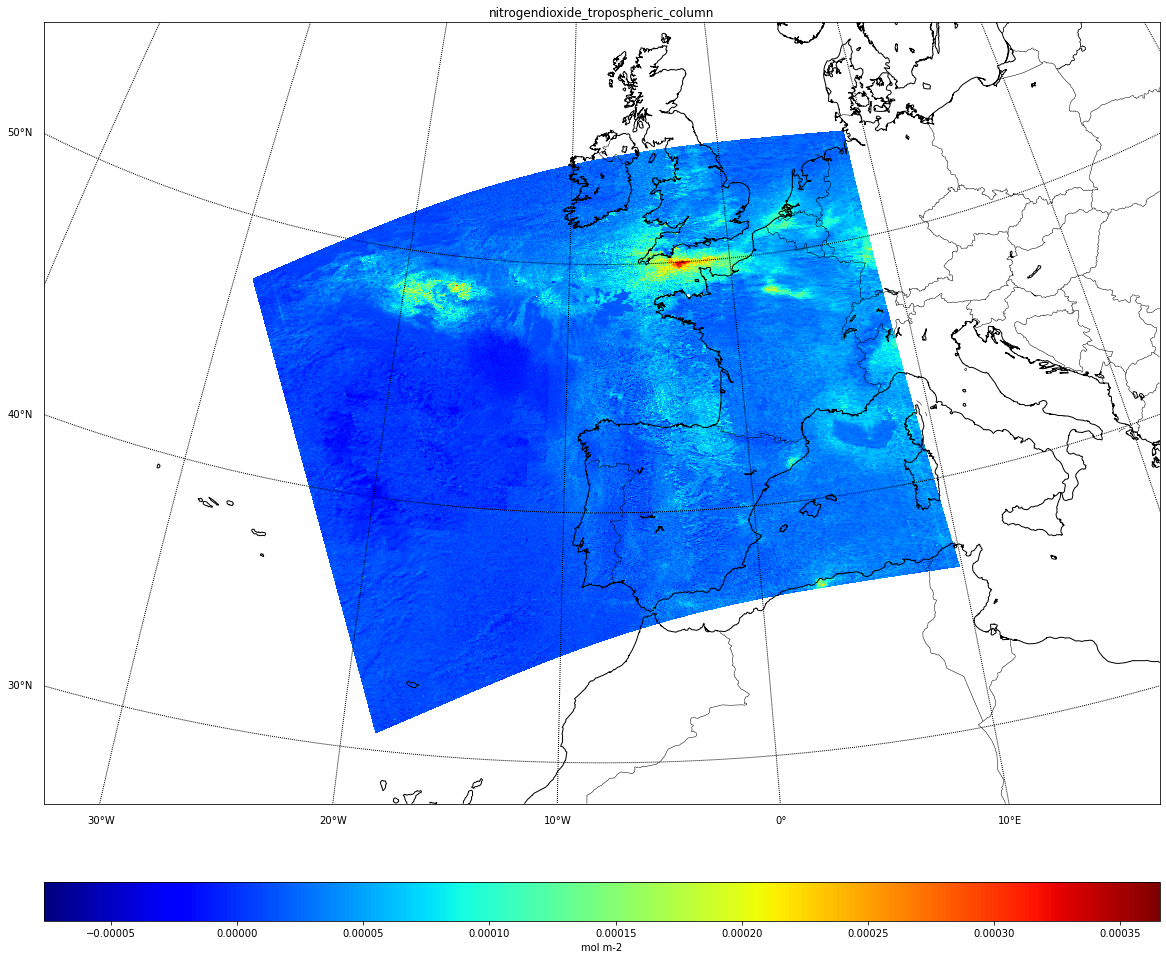

In [118]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lon_0 = lons.mean()
lat_0 = lats.mean()
plt.figure(figsize=(20,20))
map1 = Basemap(width=5000000,height=3500000,
            resolution='i',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

xi, yi = map1(lons, lats)

# Plot Data
cs = map1.pcolor(xi,yi,np.squeeze(prod), cmap='jet')

# Add Grid Lines
map1.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
map1.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
map1.drawcoastlines()
map1.drawstates()
map1.drawcountries()

# Add Colorbar
cbar = map1.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(units)

# Add Title
plt.title(products_drop.value)

plt.show()